## Run basic `scanpy` QC and doublet detection with `scrublet` for ACM murine cardiac leucocytes data set 6 month post MCMV infection after `demultiplexing` the samples

### Pkp2 Experiment 1 Library 1 (Index A1-C6)

#### Environment: Scanpy


- **Developed by**: Carlos Talavera-López PhD
- **Modified by**: Alexandra Cirnu
- **Würzburg Institute for Systems Immunology & Julius-Maximilian-Universität Würzburg**
- **Date of creation**: 230828
- **Date of modification**: 240219

#### Mouse information

Index   | Ear punch     | Genotype  | Infection
:---:   | :---:         | :---:     | :---:
1       | 21            | het ko    | PBS
2       | 22            | Ctr       | PBS
3       | 29            | Ctr       | MCMV
4       | 30            | Ctr       | MCMV
5       | 36            | Ctr       | MCMV
6       | 25            | het ko    | MCMV
7       | 26            | het ko    | MCMV
8       | 27            | het ko    | MCMV
9       | 31            | Ctr       | PBS
10      | 32            | het ko    | PBS

### Load required modules in Scanpy environment

In [229]:
import anndata
import logging
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sb
import scrublet as scr
import muon as mu
from muon import atac as ac
from muon import prot as pt
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import rcParams

In [230]:
%matplotlib inline
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 160, color_map = 'RdPu', dpi_save = 180, vector_friendly = True, format = 'svg')

-----
anndata     0.10.5.post1
scanpy      1.9.8
-----
PIL                 10.2.0
annoy               NA
appnope             0.1.4
asttokens           NA
brotli              1.1.0
certifi             2024.02.02
charset_normalizer  3.3.2
colorama            0.4.6
comm                0.2.1
cycler              0.12.1
cython_runtime      NA
dateutil            2.8.2
debugpy             1.8.1
decorator           5.1.1
exceptiongroup      1.2.0
executing           2.0.1
future              0.18.3
h5py                3.10.0
idna                3.6
igraph              0.11.4
ipykernel           6.29.2
ipywidgets          8.1.2
jedi                0.19.1
joblib              1.3.2
kiwisolver          1.4.5
lazy_loader         NA
leidenalg           0.10.2
llvmlite            0.42.0
matplotlib          3.8.3
matplotlib_inline   0.1.6
mpl_toolkits        NA
mudata              0.2.3
muon                0.1.5
natsort             8.4.0
numba               0.59.0
numpy               1.26.4
packaging 

### Read individual `anndata` objects and predict doublets per sample

In [231]:
# Create an AnnData object
mdata = mu.read_10x_mtx(
    '/Users/alex/data/ACM_cardiac_leuco/Pkp2/C6_Pkp2_Exp1_Library1/filtered_feature_bc_matrix/',                                            # the directory with the `.mtx` file
    var_names='gene_symbols',                                                                                                               # use gene symbols for the variable names (variables-axis index)
    cache=True)                                                                                                                             # write a cache file for faster subsequent reading

mdata.var_names_make_unique()                                                                                                               # makes the index unique by adding a number string to each duplicated index element
                                                                                                                                            # This is not needed if 'var_names='gene_ids' would have been used before

... reading from cache file cache/Users-alex-data-ACM_cardiac_leuco-Pkp2-C6_Pkp2_Exp1_Library1-filtered_feature_bc_matrix-matrix.h5ad


/Users/alex/miniforge3/envs/Scanpy/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [232]:
mdata

MuData object with n_obs × n_vars = 10130 × 32384
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	10130 x 32285
      var:	'gene_ids', 'feature_types'
    prot:	10130 x 99
      var:	'gene_ids', 'feature_types'

## Extract **protein** AnnData object

In [233]:
prot = mdata.mod["prot"]
prot

AnnData object with n_obs × n_vars = 10130 × 99
    var: 'gene_ids', 'feature_types'

In [234]:
prot.layers['counts'] = prot.X
prot.X = prot.layers['counts']

In [235]:
prot_counts_df = pd.DataFrame(prot.X.toarray(),
                              index=prot.obs_names,
                              columns=prot.var_names)

prot_counts_df.iloc[:10, :10]

,Hashtag1_TotalA,Hashtag2_TotalA,Hashtag3_TotalA,Hashtag4_TotalA,Hashtag5_TotalA,Hashtag6_TotalA,Hashtag7_TotalA,Hashtag8_TotalA,Hashtag9_TotalA,Hashtag10_TotalA
AAACCCAAGAACAAGG-1,12.0,32.0,10.0,92.0,14.0,29.0,14.0,246.0,220.0,81.0
AAACCCAAGAAGCGAA-1,297.0,2.0,0.0,2.0,3.0,16.0,0.0,3.0,2.0,1.0
AAACCCAAGATACAGT-1,2.0,1.0,3.0,5.0,0.0,5.0,1.0,3.0,193.0,0.0
AAACCCAAGCAATAGT-1,3.0,8.0,2.0,173.0,4.0,351.0,1.0,4.0,5.0,13.0
AAACCCAAGTCTAACC-1,2.0,1.0,0.0,2.0,1.0,4.0,130.0,3.0,0.0,1.0
AAACCCACAACCACGC-1,3.0,2.0,2.0,0.0,7.0,2.0,7.0,61.0,1.0,0.0
AAACCCACAATTTCCT-1,198.0,9.0,4.0,29.0,21.0,756.0,10.0,35.0,13.0,484.0
AAACCCACAGGCGATA-1,1.0,4.0,80.0,1.0,3.0,153.0,1.0,6.0,7.0,7.0
AAACCCACATATGCGT-1,1.0,1.0,307.0,1.0,3.0,9.0,7.0,1.0,98.0,3.0
AAACCCAGTGCTCTCT-1,1.0,4.0,3.0,19.0,0.0,7.0,0.0,1411.0,2.0,2.0


Normalize protein counts in mdata

In [236]:
pt.pp.clr(prot)
prot_counts_df.iloc[:10, :10]

,Hashtag1_TotalA,Hashtag2_TotalA,Hashtag3_TotalA,Hashtag4_TotalA,Hashtag5_TotalA,Hashtag6_TotalA,Hashtag7_TotalA,Hashtag8_TotalA,Hashtag9_TotalA,Hashtag10_TotalA
AAACCCAAGAACAAGG-1,12.0,32.0,10.0,92.0,14.0,29.0,14.0,246.0,220.0,81.0
AAACCCAAGAAGCGAA-1,297.0,2.0,0.0,2.0,3.0,16.0,0.0,3.0,2.0,1.0
AAACCCAAGATACAGT-1,2.0,1.0,3.0,5.0,0.0,5.0,1.0,3.0,193.0,0.0
AAACCCAAGCAATAGT-1,3.0,8.0,2.0,173.0,4.0,351.0,1.0,4.0,5.0,13.0
AAACCCAAGTCTAACC-1,2.0,1.0,0.0,2.0,1.0,4.0,130.0,3.0,0.0,1.0
AAACCCACAACCACGC-1,3.0,2.0,2.0,0.0,7.0,2.0,7.0,61.0,1.0,0.0
AAACCCACAATTTCCT-1,198.0,9.0,4.0,29.0,21.0,756.0,10.0,35.0,13.0,484.0
AAACCCACAGGCGATA-1,1.0,4.0,80.0,1.0,3.0,153.0,1.0,6.0,7.0,7.0
AAACCCACATATGCGT-1,1.0,1.0,307.0,1.0,3.0,9.0,7.0,1.0,98.0,3.0
AAACCCAGTGCTCTCT-1,1.0,4.0,3.0,19.0,0.0,7.0,0.0,1411.0,2.0,2.0


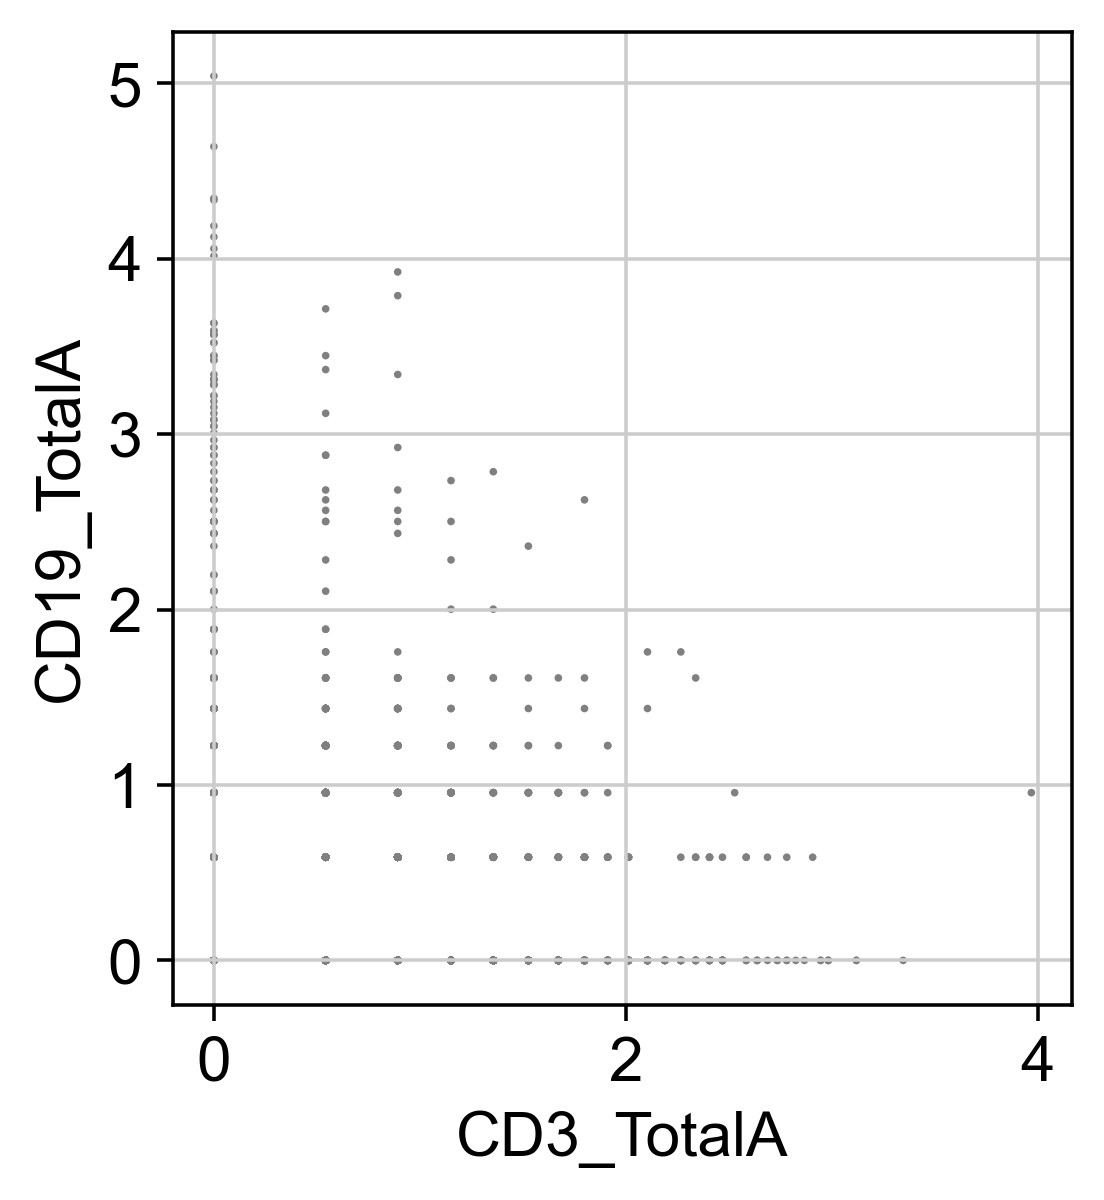

In [237]:
sc.pl.scatter(prot, x="CD3_TotalA", y="CD19_TotalA")

#### Run PCA on protein counts

In [238]:
sc.tl.pca(prot)

computing PCA
    with n_comps=50
    finished (0:00:00)


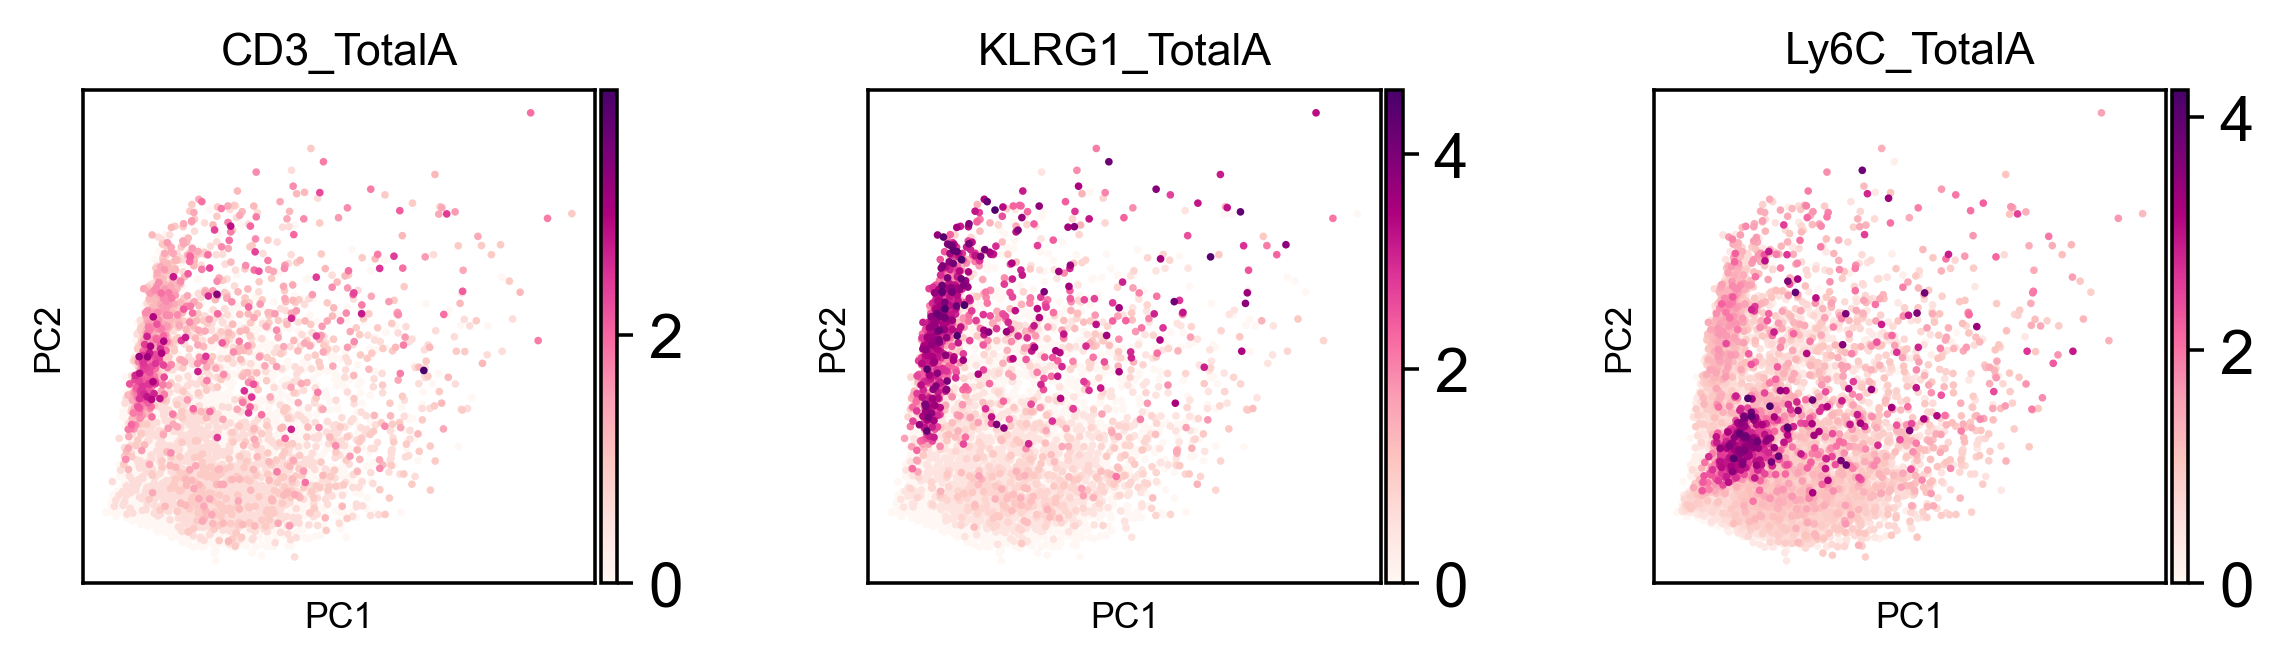

In [239]:
plt.rcParams['figure.figsize'] = (2, 2)
plt.rcParams['axes.titlesize'] = 10 
plt.rcParams['axes.labelsize'] = 8 
sc.pl.pca(prot, color=['CD3_TotalA', 'KLRG1_TotalA', 'Ly6C_TotalA'])

In [240]:
sc.pp.neighbors(prot)
sc.tl.umap(prot, random_state=1)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


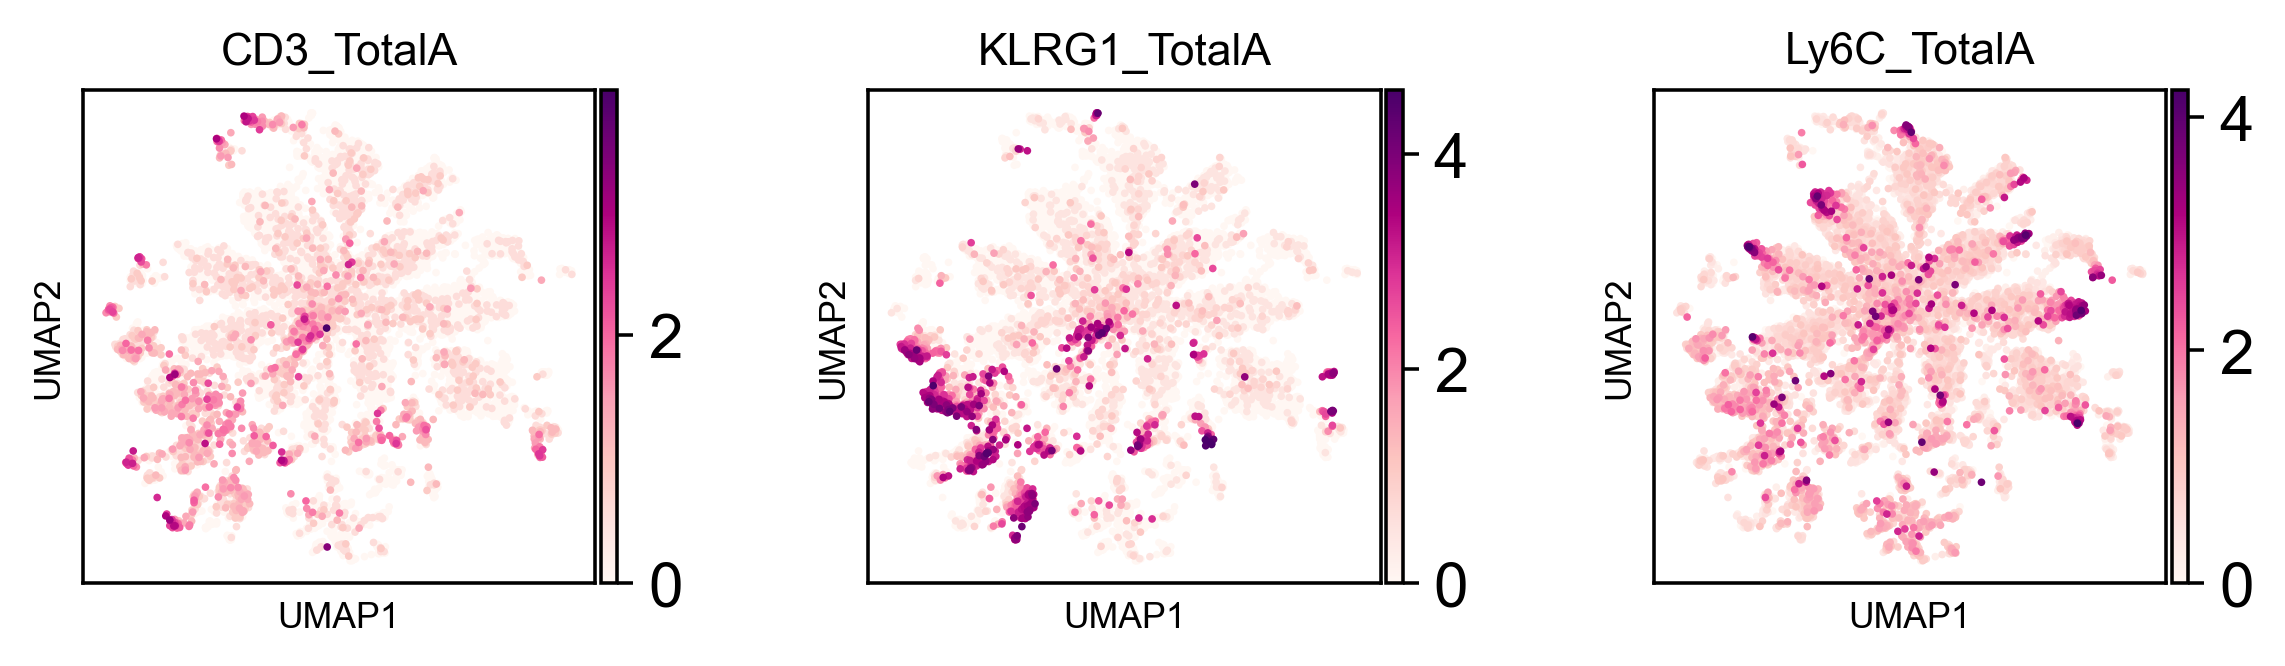

In [242]:
plt.rcParams['figure.figsize'] = (2, 2)
plt.rcParams['axes.titlesize'] = 10 
plt.rcParams['axes.labelsize'] = 8 
sc.pl.umap(prot, color=['CD3_TotalA', 'KLRG1_TotalA', 'Ly6C_TotalA'])

## Extract **RNA** AnnData object

In [243]:
rna = mdata.mod["rna"]
rna

AnnData object with n_obs × n_vars = 10130 × 32285
    var: 'gene_ids', 'feature_types'

In [244]:
A1_demux = pd.read_csv("/Users/alex/data/ACM_cardiac_leuco/Demultiplex/Pkp2_A1_demultiplex.csv", index_col= 'barcodes')
del A1_demux["Unnamed: 0"]
A1_demux

,Sample,Condition,Genotype,Infection,Library_Index
barcodes,,,,,
AAACCCAAGAAGCGAA-1,Pkp2_HetKO_noninf_1,Pkp2_HetKO_noninf,Pkp2_HetKO,noninf,A1
AAACCCAAGATACAGT-1,Pkp2_Ctr_noninf_2,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1
AAACCCAAGTCTAACC-1,Pkp2_HetKO_MCMV_2,Pkp2_HetKO_MCMV,Pkp2_HetKO,MCMV,A1
AAACCCACAACCACGC-1,Pkp2_HetKO_MCMV_3,Pkp2_HetKO_MCMV,Pkp2_HetKO,MCMV,A1
AAACCCAGTGCTCTCT-1,Pkp2_HetKO_MCMV_3,Pkp2_HetKO_MCMV,Pkp2_HetKO,MCMV,A1
...,...,...,...,...,...
TTTGTTGGTAACTGCT-1,Pkp2_Ctr_MCMV_1,Pkp2_Ctr_MCMV,Pkp2_Ctr,MCMV,A1
TTTGTTGGTAGAGGAA-1,Pkp2_HetKO_MCMV_2,Pkp2_HetKO_MCMV,Pkp2_HetKO,MCMV,A1
TTTGTTGTCAGGAAGC-1,Pkp2_Ctr_MCMV_2,Pkp2_Ctr_MCMV,Pkp2_Ctr,MCMV,A1


In [245]:
rna.obs['sample'] = A1_demux.Sample
rna.obs['condition'] = A1_demux.Condition
rna.obs['genotype'] = A1_demux.Genotype
rna.obs['infection'] = A1_demux.Infection
rna.obs['library'] = A1_demux.Library_Index
rna.obs

,sample,condition,genotype,infection,library
AAACCCAAGAACAAGG-1,NaN,NaN,NaN,NaN,NaN
AAACCCAAGAAGCGAA-1,Pkp2_HetKO_noninf_1,Pkp2_HetKO_noninf,Pkp2_HetKO,noninf,A1
AAACCCAAGATACAGT-1,Pkp2_Ctr_noninf_2,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1
AAACCCAAGCAATAGT-1,NaN,NaN,NaN,NaN,NaN
AAACCCAAGTCTAACC-1,Pkp2_HetKO_MCMV_2,Pkp2_HetKO_MCMV,Pkp2_HetKO,MCMV,A1
...,...,...,...,...,...
TTTGTTGTCAGGAAGC-1,Pkp2_Ctr_MCMV_2,Pkp2_Ctr_MCMV,Pkp2_Ctr,MCMV,A1
TTTGTTGTCCTATTTG-1,NaN,NaN,NaN,NaN,NaN
TTTGTTGTCGACCCAG-1,Pkp2_HetKO_MCMV_1,Pkp2_HetKO_MCMV,Pkp2_HetKO,MCMV,A1
TTTGTTGTCTGTGCAA-1,Pkp2_HetKO_noninf_1,Pkp2_HetKO_noninf,Pkp2_HetKO,noninf,A1


In [246]:
rna = rna[rna.obs.library == 'A1', :]
rna.obs['model'] = "Pkp2"
rna.obs

/var/folders/gv/f1jp14394j18ml09qq30lpv80000gn/T/ipykernel_23452/2352252997.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  rna.obs['model'] = "Pkp2"


,sample,condition,genotype,infection,library,model
AAACCCAAGAAGCGAA-1,Pkp2_HetKO_noninf_1,Pkp2_HetKO_noninf,Pkp2_HetKO,noninf,A1,Pkp2
AAACCCAAGATACAGT-1,Pkp2_Ctr_noninf_2,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,Pkp2
AAACCCAAGTCTAACC-1,Pkp2_HetKO_MCMV_2,Pkp2_HetKO_MCMV,Pkp2_HetKO,MCMV,A1,Pkp2
AAACCCACAACCACGC-1,Pkp2_HetKO_MCMV_3,Pkp2_HetKO_MCMV,Pkp2_HetKO,MCMV,A1,Pkp2
AAACCCAGTGCTCTCT-1,Pkp2_HetKO_MCMV_3,Pkp2_HetKO_MCMV,Pkp2_HetKO,MCMV,A1,Pkp2
...,...,...,...,...,...,...
TTTGTTGGTAACTGCT-1,Pkp2_Ctr_MCMV_1,Pkp2_Ctr_MCMV,Pkp2_Ctr,MCMV,A1,Pkp2
TTTGTTGGTAGAGGAA-1,Pkp2_HetKO_MCMV_2,Pkp2_HetKO_MCMV,Pkp2_HetKO,MCMV,A1,Pkp2
TTTGTTGTCAGGAAGC-1,Pkp2_Ctr_MCMV_2,Pkp2_Ctr_MCMV,Pkp2_Ctr,MCMV,A1,Pkp2
TTTGTTGTCGACCCAG-1,Pkp2_HetKO_MCMV_1,Pkp2_HetKO_MCMV,Pkp2_HetKO,MCMV,A1,Pkp2


In [252]:
rna

AnnData object with n_obs × n_vars = 6978 × 32285
    obs: 'sample', 'condition', 'genotype', 'infection', 'library', 'model'
    var: 'gene_ids', 'feature_types'

In [249]:
mu.pp.filter_obs(rna, 'n_genes_by_counts', lambda x: (x >= 200))

ValueError: Column name from .obs or one of the var_names was expected but got n_genes_by_counts.

In [ ]:
# Filter cells in the 'rna' modality 
sc.pp.filter_cells(mdata_subset.mod['rna'], min_genes=200)
mdata_subset.mod['rna']

In [ ]:
# Get the indices of the cells that remain in the 'rna' modality
filtered_cells_rna = mdata_subset.mod['rna'].obs_names
filtered_cells_rna

In [ ]:
# Align the 'prot' modality to include only the cells that are present in the filtered 'rna' modality
mdata_subset.mod['prot'] = mdata_subset.mod['prot'][filtered_cells_rna]
mdata_subset.mod['prot']

In [ ]:
mdata_subset.update()
mdata_subset

In [ ]:
print(mdata_subset.mod['rna'].n_obs, mdata_subset.mod['rna'].n_vars)

##### Run `scrublet` to identify doublets 

`scrublet` can identify "neotypic" doublets (from cells with different gene expression patterns) in "simulated doublets". It cannot detect "embedded" doublets generated by two cells with similar gene expression.
To call doublets vs singlets, we must set a threshold doublet score at the minimum between the two modes of the simulated doublet histogram. If `scrublet` is unable to perform this steo properly, the threshold can be adjusted by scrub.call_doublets(threshold=0.25)



In [ ]:
sample_names = mdata_subset.mod["rna"].obs['sample'].unique()

for sample_name in sample_names:
    mask = mdata_subset.mod["rna"].obs['sample'] == sample_name
    sample_adata = mdata_subset.mod['rna'][mask].copy()

    scrub = scr.Scrublet(sample_adata.X)                                                                     #Initialize Scrublet object

    sample_adata.obs['doublet_scores'], sample_adata.obs['predicted_doublets'] = scrub.scrub_doublets()     #Run the default pipline including Doublet simulation, normalization, gene filtering, rescaling, PCA, Doublet score calcualtion, doublet score calculation and doulet calling

    
    mdata_subset.mod['rna'].obs.loc[mask, 'doublet_scores'] = sample_adata.obs['doublet_scores']
    mdata_subset.mod['rna'].obs.loc[mask, 'predicted_doublets'] = sample_adata.obs['predicted_doublets']

    scrub.plot_histogram()

    plt.show()

In [ ]:
mdata_subset.mod['rna']

In [ ]:
sample_object = mdata_subset.copy()
sample_object

### Compute QC stats

In [ ]:
sample_object.shape

In [ ]:
sample_object.mod["rna"].var['mt'] = sample_object.mod["rna"].var_names.str.startswith('mt-') 
sample_object.mod["rna"].var['ribo'] = sample_object.mod["rna"].var_names.str.startswith(("Rps","Rpl"))
sample_object.mod["rna"].var

In [ ]:
sc.pp.calculate_qc_metrics(sample_object.mod["rna"], qc_vars = ['mt','ribo'], percent_top = None, log1p = False, inplace = True)

sample_object.mod["rna"]

In [ ]:
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
# add the total counts per cell as observations-annotation to adata

mito_genes = sample_object.mod["rna"].var_names.str.startswith('mt-')
sample_object.mod["rna"].obs['percent_mt'] = np.sum(
    sample_object.mod["rna"][:, mito_genes].X, axis = 1) / np.sum(sample_object.mod["rna"].X, axis = 1)
sample_object.mod["rna"].obs['n_counts'] = sample_object.mod["rna"].X.sum(axis = 1)

sample_object.mod["rna"]

### Visualise QC covariates

In [ ]:
sample_object.mod["rna"].var_names 

In [ ]:
#fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize = (5,5))

sc.pl.violin(
    sample_object.mod["rna"], 
    ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'n_genes'],
    jitter = 0.2, 
    rotation = 90, 
    multi_panel= True, 
    groupby= 'sample', )      

In [ ]:
sc.pl.scatter(
    sample_object.mod["rna"], 
    x = 'total_counts', 
    y = 'pct_counts_mt', 
    color = "sample")

In [ ]:
sc.pl.scatter(
    sample_object.mod["rna"], 
    x = 'n_genes', 
    y = 'pct_counts_mt', 
    color = "sample")

### Add sample sex covariate

In [ ]:
annot = sc.queries.biomart_annotations(
        "mmusculus",
        ["ensembl_gene_id", "external_gene_name", "start_position", "end_position", "chromosome_name"],
    ).set_index("external_gene_name")

In [ ]:
annot.head()

In [ ]:
chrY_genes = sample_object.mod["rna"].var_names.intersection(annot.index[annot.chromosome_name == "Y"])
chrY_genes

In [ ]:
sample_object.mod["rna"].obs['percent_chrY'] = np.sum(
    sample_object.mod["rna"][:, chrY_genes].X, axis = 1) / np.sum(sample_object.mod["rna"].X, axis = 1) * 100

In [ ]:
xist_counts = sample_object.mod["rna"].X[:, sample_object.mod["rna"].var_names.str.match('Xist')].toarray()
xist_counts_series = pd.Series(xist_counts.squeeze(), index = sample_object.mod["rna"].obs_names, name = "XIST-counts")
sample_object.mod["rna"].obs["XIST-counts"] = xist_counts_series

sc.pl.scatter(
    sample_object.mod["rna"], 
    x = 'XIST-counts', 
    y = 'percent_chrY', 
    color = "sample")

In [ ]:
fig, ax = plt.subplots(figsize = (10,6))
sc.pl.violin(
    sample_object.mod["rna"], 
    ["XIST-counts", "percent_chrY"], 
    jitter = 0.4, 
    rotation = 90, 
    ax=ax, 
    groupby= 'sample')   

### Calculate cell cycle scores

In [ ]:
!if [ ! -f /Users/alex/github/ACM_Mouse_Immune/data/regev_lab_cell_cycle_genes.txt ]; then curl -o ../data/regev_lab_cell_cycle_genes.txt https://raw.githubusercontent.com/theislab/scanpy_usage/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt; fi

In [ ]:
cell_cycle_genes = [x.strip() for x in open('/Users/alex/github/ACM_Mouse_Immune/data/regev_lab_cell_cycle_genes.txt')]
cell_cycle_genes = [gene.capitalize() for gene in cell_cycle_genes] #needed when analyzing mouse data
print(len(cell_cycle_genes))

# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

cell_cycle_genes = [x for x in cell_cycle_genes if x in sample_object.mod["rna"].var_names]
print(len(cell_cycle_genes))

- Create basic `anndata` for score calculation

In [ ]:
adata_log = anndata.AnnData(X = sample_object.mod["rna"].X,  var = sample_object.mod["rna"].var, obs = sample_object.mod["rna"].obs)
sc.pp.normalize_total(adata_log, target_sum = 1e6, exclude_highly_expressed = True)
sc.pp.log1p(adata_log)

In [ ]:
fig, ax = plt.subplots(figsize = (3,3))
sc.tl.score_genes_cell_cycle(adata_log, s_genes = s_genes, g2m_genes = g2m_genes)
sc.pl.violin(
    adata_log, 
    ['S_score'],
    jitter = 0.2, 
    rotation = 90, 
    ax=ax, 
    groupby = 'sample', 
    multi_panel = True)          

In [ ]:

fig, ax = plt.subplots(figsize = (3,3))
sc.pl.violin(
    adata_log, 
    ['G2M_score'],
    jitter = 0.2, 
    rotation = 90, 
    ax=ax, 
    groupby = 'sample', 
    multi_panel = True)       

In [ ]:
sample_object.mod["rna"].obs['S_score'] = adata_log.obs['S_score']
sample_object.mod["rna"].obs['G2M_score'] = adata_log.obs['G2M_score']
sample_object.mod["rna"]

In [ ]:
sc.pl.violin(
    sample_object.mod["rna"], 
    ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'doublet_scores'],
    jitter = 0.2, 
    rotation = 90, 
    multi_panel= True, 
    groupby = 'sample')           

### Prepare counts for individual slots

In [ ]:
sample_object.raw = sample_object.copy()
sample_object.mod["rna"].layers['counts'] = sample_object.mod["rna"].X.copy()
sample_object.mod["rna"].layers["sqrt_norm"] = np.sqrt(
    sc.pp.normalize_total(sample_object.mod["rna"], inplace = False)["X"]
)
sample_object

In [ ]:
del(sample_object.mod["rna"].obs['predicted_doublets'])
sample_object.mod["rna"].obs

In [ ]:
sample_object.obs = sample_object.mod["rna"].obs.copy()
sample_object.obs

### Export object - not adjusted yet!!!!

In [ ]:
sample_object.write("/Users/alex/data/ACM_cardiac_leuco/Pkp2/C6_Pkp2_Exp1_Library1/processed/Pkp2_A1_demux_not_yet_QCed_ac240219.raw.h5mu")